### Question 8:

Create a Quarto report containing the 

* regional association plot
* the total number of SNPs within that plotted region
* Lead SNP
  * rsid
  * p-value
  * beta
  * standard error

* Finally include a table of the top 5 SNPs (**ranked by p-value**) and **include all columns**.

I believe an markdown woudl also be acceptable and because I do not have Quarto installed, I decided to use jupyternotebook.

In [2]:
import os,shutil,re,glob,csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import custom package
from python_GWAS_helpers import *

#### Read in data

In [3]:
sumstat_file="/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/data/cleaned_sumstats.txt.gz"
sumstat_res = pd.read_csv(sumstat_file,sep="\t",quoting=csv.QUOTE_NONE)


#### Obtain the relevant region

This is based on Question 5:

* chromosome 7, centered around the most significant variant around position 121012647

In [4]:
# obtain the 500kb region around the variant we need
## get the most significant snp as before
targ_chrom = 7
targ_pos = 121012647
min_pos = targ_pos - 500_000
max_pos = targ_pos + 500_000
relevant_region = sumstat_res.query(
  f"chromosome == {targ_chrom} & position <= {max_pos} & position >= {min_pos}"
)
most_significant = relevant_region[relevant_region['p-value'] == relevant_region['p-value'].min()]
assert(len(most_significant) == 1),f"more than 1 sig snps...probably pick one first"

##### Create regional association plots

In [5]:
# obtain the plot data
most_sig_snp = most_significant.rs_number.to_list()[0]
most_sig_chr = most_significant.chromosome.to_list()[0]
most_sig_pos = most_significant.position.to_list()[0]
min_pos = most_sig_pos - 500_000
max_pos = most_sig_pos + 500_000
assert(most_sig_chr == 7),f"what?? it should be chr 7 cuz we queried chr 7"
plot_region = sumstat_res.query(
  f"chromosome == {most_sig_chr} & position >= {min_pos} & position <= {max_pos}"
)

# get the plot data
ld_data = pd.read_csv("/Users/kevinliang/Desktop/work/working/interview_prep/5prime/5PrimeSciences_coding_assessments/data/lead_chr7_proxy.tsv",sep="\t",quoting=csv.QUOTE_NONE)[['RS_Number',"R2"]]
plot_data = pd.merge(
  plot_region[['position','rs_number','p-value','_-log10_p-value']],
  ld_data,
  how='left',left_on=['rs_number'],right_on=['RS_Number']
).copy()
# modify stuff so the plot looks nice

## the units in mb
x_axis_units = 1_000_000
plot_data = plot_data.assign(
  pos_mb = lambda df: df['position']/x_axis_units
)
## rename so easier to reference.
plot_data = plot_data.rename(
  {
    "_-log10_p-value":"neglog10_pvalue"
  },axis=1
)
## fill in R2 without value to be 0 (so will be the same color)
plot_data['R2'] = plot_data['R2'].apply(
  lambda val: 0 if np.isnan(val) else val
)
def get_bins(val):
  if val < 0.2:
    bin_cat = "<0.2"
  elif 0.2 <= val < 0.4:
    bin_cat = "[0.2,0.4)"
  elif 0.4 <= val < 0.6:
    bin_cat = "[0.4,0.6)"
  elif 0.6 <= val < 0.8:
    bin_cat = "[0.6,0.8)"
  elif 0.8 <= val:
    bin_cat = "[0.8,1]"
  else:
    assert(False),f"what value are we doing...{val}"
  return bin_cat
plot_data['r2_bins'] = plot_data[['R2','rs_number']].apply(
  lambda df: "Query SNP" if df['rs_number'] == most_sig_snp else get_bins(df['R2']),
  axis=1
)



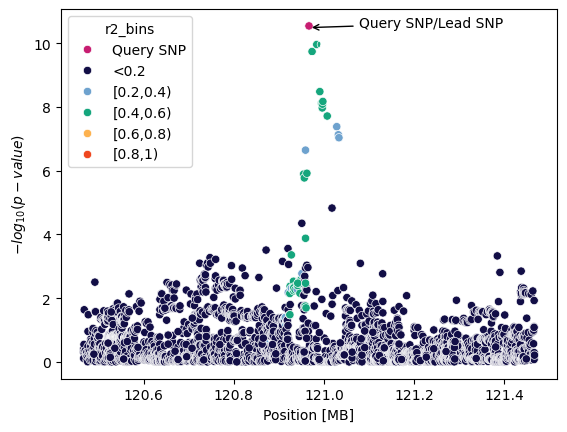

In [6]:
# create region plot
c_palette = {
  "Query SNP":"#c71d71",
  "<0.2":"#120e46",
  "[0.2,0.4)":"#6ea2ce",
  "[0.4,0.6)":"#15a67d",
  "[0.6,0.8)":"#fdb24f",
  "[0.8,1)":"#ef471f"
}

fig,ax = plt.subplots()
sns.scatterplot(
  plot_data,
  x = "pos_mb", y="neglog10_pvalue",hue="r2_bins",ax=ax,
  hue_order = list(c_palette.keys()),palette=c_palette
)
# annotate the lead snp
ax.annotate(
  "Query SNP/Lead SNP", 
  xy=(0.5,0.95),
  xytext=(0.6,0.95),
  xycoords='axes fraction',
  arrowprops=dict(arrowstyle="->",facecolor='black')
)
ax.update(
  {
    "xlabel":"Position [MB]",
    "ylabel":r"$-log_{10}(p-value)$"
  }
)
plt.show()


##### The total number of SNPs in this region

In [8]:
number_snps = len(plot_data.rs_number.unique())

print(f"The regions contained {number_snps} SNPs")

The regions contained 3471 SNPs


##### Lead snp information

In [12]:
lead_rsid = most_significant.iloc[0,:].rs_number
lead_p = "{:.3e}".format(most_significant.iloc[0,:]['p-value'])
lead_beta = np.round(most_significant.iloc[0,:]['beta'],3)
lead_se = "{:.3e}".format(most_significant.iloc[0,:]['se'])


print("Lead SNP information")
print(f"RSID: {lead_rsid}")
print(f"P-value: {lead_p}")
print(f"beta: {lead_beta}")
print(f"SE: {lead_se}")

Lead SNP information
RSID: rs3779381
P-value: 2.870e-11
beta: 0.058
SE: 8.522e-03


##### Top 5 SNPs

In [13]:
# sort by p-values in ascending and get first 5 rows
top_5_snps = sumstat_res.sort_values(by = ['p-value'],ascending=True).head(n=5)
top_5_snps

,chromosome,position,rs_number,reference_allele,other_allele,eaf,beta,se,beta_95L,beta_95U,z,p-value,_-log10_p-value,q_statistic,q_p-value,i2,n_studies,n_samples,effects
3156956,5,88376061,rs1366594,C,A,0.522593,-0.079453,0.007525,-0.094201,-0.064704,-10.559028,5.440000e-25,24.264540,23.081408,0.003261,0.653401,9,-9,---------
3156923,5,88354675,rs10037512,C,T,0.520605,-0.079029,0.007542,-0.093812,-0.064247,-10.478665,1.230000e-24,23.910103,20.903614,0.007408,0.617291,9,-9,---------
3156943,5,88364958,rs6886306,T,C,0.520525,-0.078600,0.007535,-0.093368,-0.063832,-10.431872,1.970000e-24,23.704955,24.425982,0.001944,0.672480,9,-9,---------
3156859,5,88327782,rs6894139,G,T,0.513206,-0.077077,0.007532,-0.091840,-0.062315,-10.233386,1.430000e-23,22.844782,24.082231,0.002220,0.667805,9,-9,---------
3156833,5,88306561,rs4916664,T,C,0.533015,-0.074690,0.007550,-0.089488,-0.059893,-9.893158,3.910000e-22,21.408115,24.864423,0.001639,0.678255,9,-9,---------
